In [1]:
# Standard Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

# Modeling Imports
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential, regularizers, Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import (Dense, Flatten, Input, Dropout, 
                                     Add, BatchNormalization, Activation, 
                                     Conv2D, MaxPooling2D)

from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, 
                             accuracy_score, precision_score)
from sklearn.utils import class_weight

# Lime Imports
%load_ext autoreload
%autoreload 2
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

import sys
sys.path.append(os.path.join(os.pardir, os.pardir, 'src'))
import functions as fx

In [2]:
train_path = os.path.join(os.pardir, os.pardir, 'data', 'train')
test_path = os.path.join(os.pardir, os.pardir, 'data', 'test')

train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 30, zoom_range = 0.3,
                                   width_shift_range = 0.2, height_shift_range = 0.2,
                                   horizontal_flip = True, brightness_range = [0.5, 1.5], 
                                   validation_split = 0.1)
val_datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.1)
train_generator = train_datagen.flow_from_directory(
    train_path, seed = 55, target_size = (256, 256), 
    batch_size = 64, class_mode = 'binary', 
    classes = ['perennials', 'weeds'], subset = 'training')
val_generator = val_datagen.flow_from_directory(
    train_path, seed = 55, target_size = (256, 256),
    batch_size = 64, class_mode = 'binary', 
    classes = ['perennials', 'weeds'], subset = 'validation')
test_generator = ImageDataGenerator(rescale = 1./255.) \
    .flow_from_directory(test_path, target_size = (256, 256), 
                         batch_size = 64, class_mode = 'binary', 
                         classes = ['perennials', 'weeds'])

Found 4698 images belonging to 2 classes.
Found 521 images belonging to 2 classes.
Found 580 images belonging to 2 classes.


In [3]:
# Calculate weights to balance perennial and weed data in training set
class_weights = class_weight.compute_class_weight(
    class_weight = 'balanced', classes = np.unique(train_generator.classes), 
    y = train_generator.classes)
train_class_weights = dict(enumerate(class_weights))

# Stop training if training accuracy does not decrease in 5 epochs
early_stop_loss = EarlyStopping(monitor = 'accuracy', patience = 10, restore_best_weights = True)

In [4]:
def final_l2(image):
    layers = [
        Input(image.shape),
        Conv2D(16, (5, 5), activation = 'relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Conv2D(32, (5, 5), activation = 'relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Conv2D(64, (5, 5), activation = 'relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Flatten(),
        Dense(512, activation = 'relu', kernel_regularizer = regularizers.l2(0.01)),
        Dense(256, activation = 'relu', kernel_regularizer = regularizers.l2(0.01)),
        Dense(128, activation = 'relu'),
        Dense(64, activation = 'relu'),
        Dense(1, activation = 'sigmoid')
    ]
    model = Sequential(layers)
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy', 'Precision'])
    return model

In [5]:
final_l2_model = final_l2(train_generator[0][0][0])
final_l2_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 252, 252, 16)      1216      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 16)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 16)      64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 122, 122, 32)      12832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 61, 61, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 57, 57, 64)        5

In [6]:
final_l2_result = final_l2_model.fit(train_generator, epochs = 75, validation_data=val_generator,
                               class_weight = train_class_weights, callbacks = [early_stop_loss])

Epoch 1/75
74/74 [==============================] - 134s 2s/step - loss: 9.2809 - accuracy: 0.6603 - precision: 0.6660 - val_loss: 3.9922 - val_accuracy: 0.5067 - val_precision: 0.8235
Epoch 2/75
74/74 [==============================] - 132s 2s/step - loss: 2.9976 - accuracy: 0.7275 - precision: 0.7197 - val_loss: 2.5776 - val_accuracy: 0.5144 - val_precision: 0.5144
Epoch 3/75
74/74 [==============================] - 132s 2s/step - loss: 2.0409 - accuracy: 0.7356 - precision: 0.7268 - val_loss: 2.1423 - val_accuracy: 0.5144 - val_precision: 0.5144
Epoch 4/75
74/74 [==============================] - 132s 2s/step - loss: 1.5131 - accuracy: 0.7565 - precision: 0.7468 - val_loss: 1.7478 - val_accuracy: 0.5298 - val_precision: 0.5225
Epoch 5/75
74/74 [==============================] - 132s 2s/step - loss: 1.1583 - accuracy: 0.7646 - precision: 0.7561 - val_loss: 1.8918 - val_accuracy: 0.5278 - val_precision: 0.5214
Epoch 6/75
74/74 [==============================] - 132s 2s/step - loss: 0.

74/74 [==============================] - 132s 2s/step - loss: 0.4241 - accuracy: 0.8668 - precision: 0.8837 - val_loss: 1.0591 - val_accuracy: 0.6987 - val_precision: 0.7937
Epoch 46/75
74/74 [==============================] - 132s 2s/step - loss: 0.4627 - accuracy: 0.8665 - precision: 0.8785 - val_loss: 1.1199 - val_accuracy: 0.5681 - val_precision: 0.8644
Epoch 47/75
74/74 [==============================] - 132s 2s/step - loss: 0.4450 - accuracy: 0.8670 - precision: 0.8779 - val_loss: 1.0470 - val_accuracy: 0.6833 - val_precision: 0.7102
Epoch 48/75
74/74 [==============================] - 132s 2s/step - loss: 0.4295 - accuracy: 0.8763 - precision: 0.8875 - val_loss: 1.1931 - val_accuracy: 0.6392 - val_precision: 0.6274
Epoch 49/75
74/74 [==============================] - 131s 2s/step - loss: 0.4321 - accuracy: 0.8793 - precision: 0.8945 - val_loss: 1.0957 - val_accuracy: 0.6065 - val_precision: 0.5981
Epoch 50/75
74/74 [==============================] - 131s 2s/step - loss: 0.4244 -

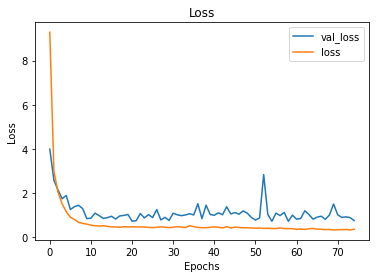

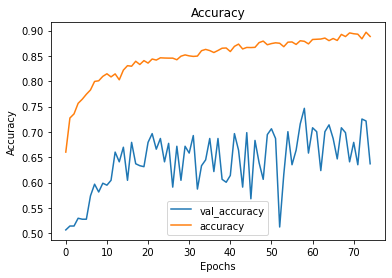

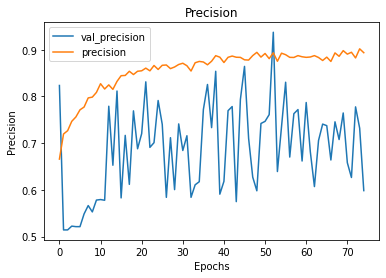

In [7]:
fx.visualize_training_results(final_l2_result, 'final_l2')

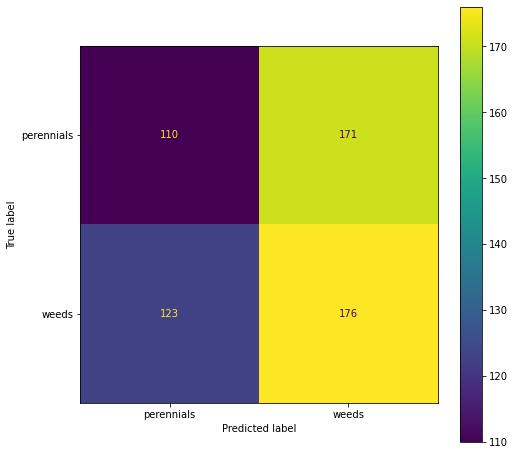

In [8]:
fx.create_confusion_matrix(final_l2_model, test_generator, 'final_l2')

In [9]:
fx.get_metrics(final_l2_model, test_generator)

Accuracy: 0.5310344827586206
Precision: 0.5389048991354467


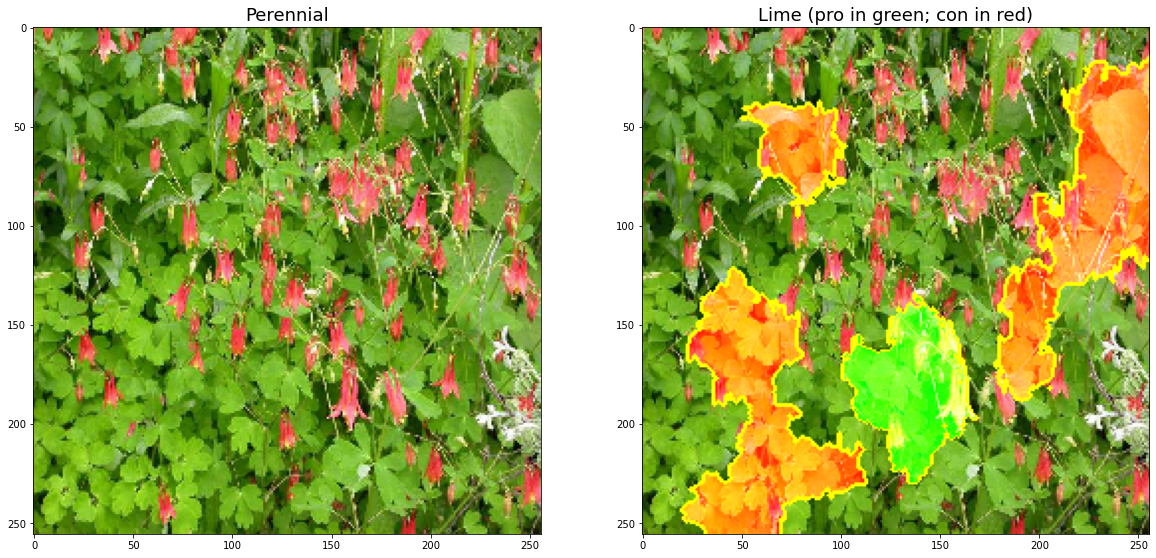

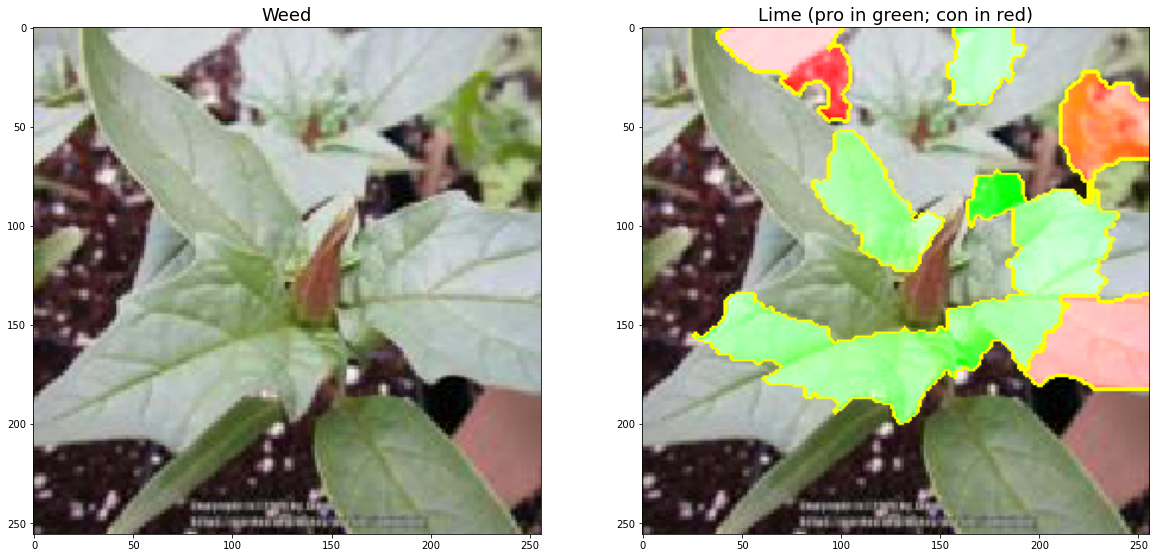

In [10]:
fx.display_lime(final_l2_model, test_generator, 'final_l2')